# Forecast Counts

* The final purpose is to forecast the purchase_amount and client_count.
* There is a solution to make more accurate forecasting and also able to return the customer understandable numbers:
  * Forecast with Prophet & Moving Window for logged moving average time series.
  * Get `exp()` value for the forcasted values, and that's the wanted values.
    * Prophet is able to handle mising data, so we even no need to worry about the missing days from the moving average ts.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# the logger here is to remove the warnings about plotly
import logging
logger = logging.getLogger('fbprophet.plot')
logger.setLevel(logging.CRITICAL)
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

In [2]:
sample_train_df1 = pd.read_pickle('sample_train_df1.pkl')
sample_test_df1 = pd.read_pickle('sample_test_df1.pkl')
print(sample_train_df1.shape, sample_test_df1.shape)

sample_train_df2 = pd.read_pickle('sample_train_df2.pkl')
sample_test_df2 = pd.read_pickle('sample_test_df2.pkl')
print(sample_train_df2.shape, sample_test_df2.shape)

sample_train_df1.head()

(100, 2) (14, 2)
(100, 2) (10, 2)


,purchase_amount,client_count
purchase_date,,
2019-02-11,58743.49,470
2019-02-12,73984.82,686
2019-02-13,95749.55,876
2019-02-14,118723.62,1095
2019-02-15,152350.76,1379


In [3]:
train1_col = sample_train_df1['client_count']
train2_col = sample_train_df2['client_count']
test1_col = sample_test_df1['client_count']
test2_col = sample_test_df2['client_count']

# Generate logged moving average for both time series sequences
ts_log_train1 = np.log(train1_col)
ts_moving_avg_train1 = ts_log_train1.rolling(window=4,center=False).mean()
ts_log_test1 = np.log(test1_col)
ts_moving_avg_test1 = ts_log_test1.rolling(window=4,center=False).mean()

ts_log_train2 = np.log(train2_col)
ts_moving_avg_train2 = ts_log_train2.rolling(window=4,center=False).mean()
ts_log_test2 = np.log(test2_col)
ts_moving_avg_test2 = ts_log_test2.rolling(window=4,center=False).mean()

print(ts_moving_avg_train1.shape, ts_moving_avg_train2.shape, ts_moving_avg_test1.shape, ts_moving_avg_test2.shape)
ts_moving_avg_test1.head()

(100,) (100,) (14,) (10,)


purchase_date
2019-05-22         NaN
2019-05-23         NaN
2019-05-24         NaN
2019-05-25    3.748604
2019-05-26    3.671921
Name: client_count, dtype: float64

In [16]:
ts_ma_train1 = pd.DataFrame(ts_moving_avg_train1.copy())
ts_ma_train1['ds'] = ts_ma_train1.index
ts_ma_train1['y'] = ts_moving_avg_train1.values
ts_ma_train1.drop(['client_count'], inplace=True, axis=1)
print(ts_ma_train1.shape)

ts_ma_test1 = pd.DataFrame(ts_moving_avg_test1.copy())
ts_ma_test1['ds'] = ts_ma_test1.index
ts_ma_test1['y'] = ts_moving_avg_test1.values
ts_ma_test1.drop(['client_count'], inplace=True, axis=1)
print(ts_ma_test1.shape)

ts_ma_train2 = pd.DataFrame(ts_moving_avg_train2.copy())
ts_ma_train2['ds'] = ts_ma_train2.index
ts_ma_train2['y'] = ts_moving_avg_train2.values
ts_ma_train2.drop(['client_count'], inplace=True, axis=1)
print(ts_ma_train2.shape)

ts_ma_test2 = pd.DataFrame(ts_moving_avg_test2.copy())
ts_ma_test2['ds'] = ts_ma_test2.index
ts_ma_test2['y'] = ts_moving_avg_test2.values
ts_ma_test2.drop(['client_count'], inplace=True, axis=1)
print(ts_ma_test2.shape)

ts_ma_train1.head()

(100, 2)
(14, 2)
(100, 2)
(10, 2)


,ds,y
purchase_date,,
2019-02-11,2019-02-11,NaN
2019-02-12,2019-02-12,NaN
2019-02-13,2019-02-13,NaN
2019-02-14,2019-02-14,6.614372
2019-02-15,2019-02-15,6.883467


In [17]:
def geterate_train_test_sequences(all_ts, forecast_ts, train_period, test_period):
    """
    It divide a whole time series into multiple train-test sequences.
    
    @param all_ts: The whole time series. Its index is the date.
    @param forecast_ts: The final testing data.
    @param train_period: The number of days in the training data.
    @param test_period: The number of days in the testing data.
    @return: A dictionary where stores the index and each (train, test) pair.
    """
    seq_idx = 0
    train_test_dct = {}
    
    train_idx = 0
    
    while train_idx <= len(all_ts)-train_period-test_period:
        train_seq = all_ts[train_idx:train_idx+train_period]
        test_seq = all_ts[train_idx+train_period:train_idx+train_period+test_period]
        
        train_test_dct[seq_idx] = {'train': train_seq, 'test': test_seq}
        
        train_idx += test_period
        seq_idx += 1
        
    train_seq = all_ts[train_idx:]
    train_test_dct[seq_idx] = {'train': train_seq, 'test': forecast_ts}
        
    return train_test_dct

In [18]:
ts_ma1_train_test_dct = geterate_train_test_sequences(ts_ma_train1, ts_ma_test1, train_period=14, test_period=7)
ts_ma2_train_test_dct = geterate_train_test_sequences(ts_ma_train2, ts_ma_test2, train_period=14, test_period=7)

In [56]:
# We just need to forecast the last moving window to see how this works :)
last_pair1 = ts_ma1_train_test_dct[len(ts_ma1_train_test_dct)-1]

train = last_pair1['train']
test = last_pair1['test']

prophet_model = Prophet(daily_seasonality = True, yearly_seasonality=False, weekly_seasonality=False,
                            seasonality_mode = 'multiplicative', n_changepoints=5,
                            changepoint_prior_scale=0.05, seasonality_prior_scale=0.1)
prophet_model.fit(train)
    
periods = len(test.index)
future = prophet_model.make_future_dataframe(periods=periods)
forecast = prophet_model.predict(future)

print(train.shape, test.shape, forecast.shape)
all_ts = train.append(test).dropna()
selected_forecast = forecast.loc[forecast['ds'].isin(all_ts.index)]
rmse = round(sqrt(mean_squared_error(all_ts['y'].values, selected_forecast['yhat'].values)), 4)
print(rmse)

forecast.head()

(16, 2) (14, 2) (30, 16)
0.2528


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-05-06,4.935059,5.708875,5.747433,4.935059,4.935059,0.160763,0.160763,0.160763,0.160763,0.160763,0.160763,0.0,0.0,0.0,5.728437
1,2019-05-07,4.874201,5.639262,5.677951,4.874201,4.874201,0.160763,0.160763,0.160763,0.160763,0.160763,0.160763,0.0,0.0,0.0,5.657794
2,2019-05-08,4.813342,5.566571,5.607313,4.813342,4.813342,0.160763,0.160763,0.160763,0.160763,0.160763,0.160763,0.0,0.0,0.0,5.587152
3,2019-05-09,4.715033,5.452409,5.493194,4.715033,4.715033,0.160763,0.160763,0.160763,0.160763,0.160763,0.160763,0.0,0.0,0.0,5.473038
4,2019-05-10,4.616724,5.337844,5.378858,4.616724,4.616724,0.160763,0.160763,0.160763,0.160763,0.160763,0.160763,0.0,0.0,0.0,5.358924


In [57]:
exp_forecast = forecast[['ds', 'yhat']]
exp_forecast['y_origin'] = np.exp(exp_forecast['yhat'])
exp_forecast.head()

,ds,yhat,y_origin
0,2019-05-06,5.728437,307.488151
1,2019-05-07,5.657794,286.515906
2,2019-05-08,5.587152,266.974074
3,2019-05-09,5.473038,238.182697
4,2019-05-10,5.358924,212.496279


(30, 1)


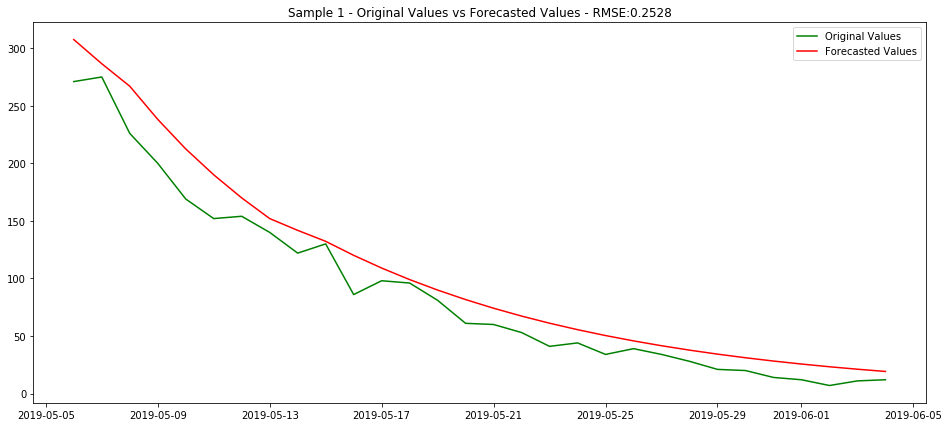

In [58]:
original_ts = sample_train_df1.iloc[sample_train_df1.index.isin(train.index)][['client_count']]
original_ts = original_ts.append(sample_test_df1[['client_count']])
print(original_ts.shape)

plt.figure(figsize=(16,7))
plt.plot(original_ts.index, original_ts, label='Original Values', color='green')
plt.plot(exp_forecast['ds'], exp_forecast['y_origin'].values, label='Forecasted Values', color='red')
plt.legend(loc='best')
plt.title("Sample 1 - Original Values vs Forecasted Values - RMSE:" + str(rmse))
plt.show()

In [59]:
last_pair2 = ts_ma2_train_test_dct[len(ts_ma2_train_test_dct)-1]

train = last_pair2['train']
test = last_pair2['test']

prophet_model = Prophet(daily_seasonality = True, yearly_seasonality=False, weekly_seasonality=False,
                            seasonality_mode = 'multiplicative', n_changepoints=5,
                            changepoint_prior_scale=0.05, seasonality_prior_scale=0.1)
prophet_model.fit(train)
    
periods = len(test.index) + 2
future = prophet_model.make_future_dataframe(periods=periods)
forecast = prophet_model.predict(future)

print(train.shape, test.shape, forecast.shape)
all_ts = train.append(test).dropna()
selected_forecast = forecast.loc[forecast['ds'].isin(all_ts.index)]
rmse = round(sqrt(mean_squared_error(all_ts['y'].values, selected_forecast['yhat'].values)), 4)
print(rmse)

forecast.head()

(16, 2) (10, 2) (28, 16)
0.3247


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-05-06,2.464687,2.297577,2.637759,2.464687,2.464687,0.002622,0.002622,0.002622,0.002622,0.002622,0.002622,0.0,0.0,0.0,2.471151
1,2019-05-07,2.367047,2.201594,2.553415,2.367047,2.367047,0.002622,0.002622,0.002622,0.002622,0.002622,0.002622,0.0,0.0,0.0,2.373255
2,2019-05-08,2.269407,2.102182,2.454070,2.269407,2.269407,0.002622,0.002622,0.002622,0.002622,0.002622,0.002622,0.0,0.0,0.0,2.275359
3,2019-05-09,2.171767,2.005852,2.362778,2.171767,2.171767,0.002622,0.002622,0.002622,0.002622,0.002622,0.002622,0.0,0.0,0.0,2.177463
4,2019-05-10,2.074128,1.903750,2.256779,2.074128,2.074128,0.002622,0.002622,0.002622,0.002622,0.002622,0.002622,0.0,0.0,0.0,2.079567


In [62]:
exp_forecast = forecast[['ds', 'yhat']]
exp_forecast['y_origin'] = np.exp(exp_forecast['yhat'])
exp_forecast.head()

,ds,yhat,y_origin
0,2019-05-06,2.471151,11.836058
1,2019-05-07,2.373255,10.732265
2,2019-05-08,2.275359,9.731408
3,2019-05-09,2.177463,8.823888
4,2019-05-10,2.079567,8.001000


(26, 1)


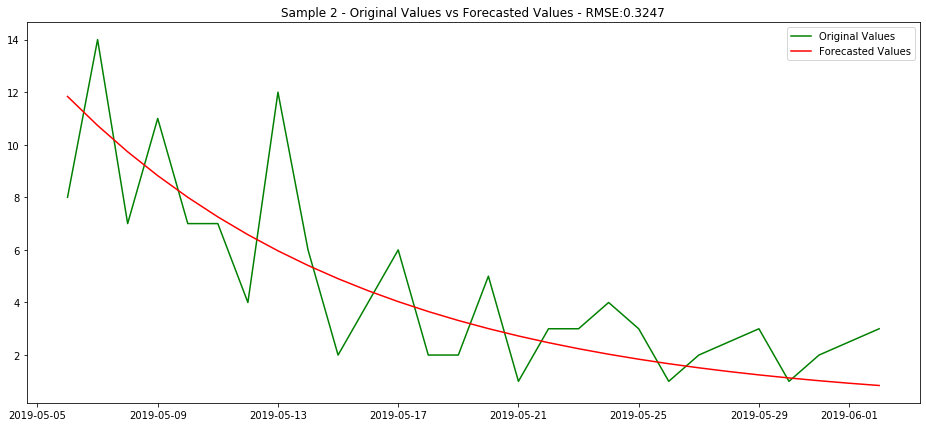

In [63]:
original_ts = sample_train_df2.iloc[sample_train_df2.index.isin(train.index)][['client_count']]
original_ts = original_ts.append(sample_test_df2[['client_count']])
print(original_ts.shape)

plt.figure(figsize=(16,7))
plt.plot(original_ts.index, original_ts, label='Original Values', color='green')
plt.plot(exp_forecast['ds'], exp_forecast['y_origin'].values, label='Forecasted Values', color='red')
plt.legend(loc='best')
plt.title("Sample 2 - Original Values vs Forecasted Values - RMSE:" + str(rmse))
plt.show()

## What to Show on User Interface

* The forecasting plot (red curve).
* "y_origin" in `exp_forecast` are the forecasted daily values.